In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923, outputs
from pudl import clean_eia923, clean_ferc1, clean_pudl, mcoe
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.options.mode.chained_assignment = None
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56
pd.options.display.max_rows = 100

In [2]:
pudl_engine  = pudl.connect_db()

# Pulling the required tables

In [3]:
g9_summed = mcoe.generation_pull_eia923(pudl_engine)
g8, g8_es = mcoe.generators_pull_eia860(pudl_engine)
frc9_summed, frc9_summed_plant = mcoe.fuel_reciepts_costs_pull_eia923(pudl_engine)
bga8 = mcoe.boiler_generator_pull_eia860(pudl_engine)
bf9_summed, bf9_plant_summed = mcoe.boiler_fuel_pull_eia923(pudl_engine)

## This forcing of energy source column to coal is problematic & needs to be undone

In [4]:
# change energy source column to coal
# frc9['energy_source'] = 'Coal'

In [5]:
# Get yearly fuel cost by plant_id, year and energy_source
# frc9_summed = analysis.yearly_sum_eia(frc9 , 'fuel_cost', columns=['plant_id_eia', 'plant_id_pudl','report_year','energy_source_cons']) #toggle
# frc9_summed = frc9_summed.reset_index()
# frc9_summed = frc9_summed.rename(columns={'primary_fuel': 'energy_source'})

In [6]:
frc9_summed.head()

,plant_id_eia,report_year,energy_source_cons,mmbtu_es,plant_id_pudl,fuel_cost_es,fuel_cost_per_mmbtu_es
0,3,2009,coal,8.784741e+07,32,3.019373e+08,3.437065
1,3,2009,gas,4.316773e+07,32,1.881205e+08,4.357896
2,3,2010,coal,8.315514e+07,32,3.124745e+08,3.757729
3,3,2010,gas,5.171804e+07,32,2.463235e+08,4.762817
4,3,2011,coal,4.714560e+07,32,2.025195e+08,4.295619


In [7]:
# frc9_mmbtu_summed = analysis.yearly_sum_eia(frc9 , 'mmbtu', columns=['plant_id_eia', 'plant_id_pudl','report_year','energy_source_cons']) #toggle
# # frc9_mmbtu_summed = frc9_mmbtu_summed.rename(columns={'primary_fuel': 'energy_source'})
# frc9_mmbtu_summed = frc9_mmbtu_summed.reset_index()
# frc9_mmbtu_summed.head(2)

In [8]:
# frc9_summed = frc9_mmbtu_summed.merge(frc9_summed)
# frc9_summed['fuel_cost_per_mmbtu_average'] = (frc9_summed.fuel_cost/frc9_summed.mmbtu)
# frc9_summed.head()

### Generators EIA923

In [9]:
# Convert the generation_eia923 table into a dataframe
g9_summed = mcoe.generation_pull_eia923(pudl_engine)

## ONLY COAL PLANTS:
#subset the g9 data frame to only coal plants
# # g9 = g9[g9['plant_id_eia'].isin(plants)]

# # Get yearly net generation by plant_id, year and generator_id
# g9_summed = analysis.yearly_sum_eia(g9, 'net_generation_mwh', columns=['report_year','plant_id_eia', 'plant_id_pudl', 'generator_id'])
# g9_summed.reset_index(inplace=True)

In [10]:
g9_summed.head()

,report_year,plant_id_eia,plant_id_pudl,generator_id,net_generation_mwh
0,2009,3,32,1,221908.0
1,2009,3,32,2,394031.0
2,2009,3,32,3,1286393.0
3,2009,3,32,4,1626547.0
4,2009,3,32,5,4513101.0


In [11]:
g9_summed[g9_summed["plant_id_pudl"]==217].head()

,report_year,plant_id_eia,plant_id_pudl,generator_id,net_generation_mwh
476,2009,1091,217,1,884849.0
477,2009,1091,217,2,1843117.0
478,2009,1091,217,3,3605713.0
1694,2009,7343,217,4,3980138.0
3405,2010,1091,217,1,913140.0


### Generators EIA860

In [12]:
# Convert the generators_eia860 table into a dataframe
g8, g8_es = mcoe.generators_pull_eia860(pudl_engine)
# g8 = analysis.simple_select('generators_eia860', pudl_engine)

In [13]:
# In order to use the energy source associated with each generator
#subset the g8 data frame to only coal plants

# g8_es['energy_source'] = 'Coal'
# g8 = g8[g8['plant_id_eia'].isin(plants)]
# g8_es = g8_es[g8_es['plant_id_eia'].isin(plants)]

In [14]:
g8.head()

,plant_id_eia,plant_id_pudl,plant_name,operator_name,state,generator_id,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,report_year
76524,3032,3037,Prospect 1,PacifiCorp,OR,1,3.8,4.6,4.6,2016
76620,2,853,Bankhead Dam,Alabama Power Co,AL,1,53.9,56.0,52.0,2016
76621,3,32,Barry,Alabama Power Co,AL,1,153.1,55.0,55.0,2016
76622,3,32,Barry,Alabama Power Co,AL,2,153.1,55.0,55.0,2016
76623,3,32,Barry,Alabama Power Co,AL,4,403.7,362.0,362.0,2016


In [15]:
# In order to use the capacity of each generator
# g8 = g8[['plant_id_eia','plant_id_pudl','report_year','plant_name', 'operator_name', 'state', 'generator_id','nameplate_capacity_mw','summer_capacity_mw','winter_capacity_mw']]


In [16]:
# re-assign all energy source values to coal
# g8['energy_source'] = 'Coal'

### Calculate a generator's proportion of plant capacity

In [17]:
# capacity_eia = analysis.capacity_proportion_eia923(g8, id_col='plant_id_eia')
# capacity_pudl = analysis.capacity_proportion_eia923(g8, id_col='plant_id_pudl')

### Boiler Fuel EIA923

In [18]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = mcoe.boiler_fuel_pull_eia923(pudl_engine)

In [19]:
# #subset the bf9 data frame to only coal plants
# bf9 = bf9[bf9['plant_id_eia'].isin(plants)]

# # re-assign all energy source values to coal
# bf9['energy_source'] = 'Coal'

In [20]:
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = bf9[0]
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_plant_summed = bf9[1]

### Boiler Generator Association EIA860

In [21]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = mcoe.boiler_generator_pull_eia860(pudl_engine)

In [22]:
# get the primary fuel for each plant (to be used to combine plants that have unassociated generators)
gf9 = analysis.simple_select('generation_fuel_eia923', pudl_engine)
# primary_fuel = analysis.primary_fuel_gf_eia923(gf9).rename(columns={'year':'report_date'})

In [23]:
#subset the bf9 data frame to only coal plants
# gf9 = gf9[gf9['plant_id_eia'].isin(plants)]

In [24]:
g9_summed.head(2)

,report_year,plant_id_eia,plant_id_pudl,generator_id,net_generation_mwh
0,2009,3,32,1,221908.0
1,2009,3,32,2,394031.0


In [25]:
g8.head(2)

,plant_id_eia,plant_id_pudl,plant_name,operator_name,state,generator_id,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,report_year
76524,3032,3037,Prospect 1,PacifiCorp,OR,1,3.8,4.6,4.6,2016
76620,2,853,Bankhead Dam,Alabama Power Co,AL,1,53.9,56.0,52.0,2016


In [26]:
g9_summed.head()

,report_year,plant_id_eia,plant_id_pudl,generator_id,net_generation_mwh
0,2009,3,32,1,221908.0
1,2009,3,32,2,394031.0
2,2009,3,32,3,1286393.0
3,2009,3,32,4,1626547.0
4,2009,3,32,5,4513101.0


## Generating Capacity Factor

In [27]:
capacity_factor = analysis.capacity_factor(g9_summed,g8, id_col='plant_id_eia')

In [28]:
capacity_factor.head(2)

,report_year,plant_id_eia,plant_id_pudl,generator_id,net_generation_mwh,plant_name,operator_name,state,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,2011,3,32,1,312130.0,Barry,Alabama Power Co,AL,153.1,138.0,138.0,0.232732
1,2011,3,32,2,191475.0,Barry,Alabama Power Co,AL,153.1,137.0,137.0,0.142769


In [29]:
testplant = capacity_factor[capacity_factor['plant_id_pudl']==217]
# testplant = capacity_factor[capacity_factor['plant_id_eia']==7343]
# testplant = capacity_factor[capacity_factor['plant_id_eia']==1091]

In [30]:
testplant.head(8)

,report_year,plant_id_eia,plant_id_pudl,generator_id,net_generation_mwh,plant_name,operator_name,state,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
468,2011,1091,217,1,843406.0,George Neal North,MidAmerican Energy Co,IA,147.0,140.4,140.4,0.654961
469,2011,1091,217,2,1643066.0,George Neal North,MidAmerican Energy Co,IA,349.2,293.8,293.8,0.537127
470,2011,1091,217,3,3166940.0,George Neal North,MidAmerican Energy Co,IA,549.8,522.2,522.2,0.657553
1660,2011,7343,217,4,4280672.0,George Neal South,MidAmerican Energy Co,IA,640.0,645.1,645.1,0.763533
3465,2012,1091,217,1,412755.0,George Neal North,MidAmerican Energy Co,IA,147.0,134.3,134.3,0.320532
3466,2012,1091,217,2,1188183.0,George Neal North,MidAmerican Energy Co,IA,349.2,283.7,283.7,0.388423
3467,2012,1091,217,3,2562669.0,George Neal North,MidAmerican Energy Co,IA,549.8,491.9,491.9,0.532088
4667,2012,7343,217,4,4335091.0,George Neal South,MidAmerican Energy Co,IA,640.0,644.8,644.8,0.773240


## Generating Heat Rate

In [31]:
# Calculate heat rate here (instead of with function) to retain 
# some of the underlying fields used for calculations

In [32]:
g9_summed.head(2)

,report_year,plant_id_eia,plant_id_pudl,generator_id,net_generation_mwh
0,2009,3,32,1,221908.0
1,2009,3,32,2,394031.0


In [33]:
gens_with_bga = mcoe.gens_with_bga(bga8, g9_summed, id_col='plant_id_pudl')

In [34]:
g8.head(5)

,plant_id_eia,plant_id_pudl,plant_name,operator_name,state,generator_id,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,report_year
76524,3032,3037,Prospect 1,PacifiCorp,OR,1,3.8,4.6,4.6,2016
76620,2,853,Bankhead Dam,Alabama Power Co,AL,1,53.9,56.0,52.0,2016
76621,3,32,Barry,Alabama Power Co,AL,1,153.1,55.0,55.0,2016
76622,3,32,Barry,Alabama Power Co,AL,2,153.1,55.0,55.0,2016
76623,3,32,Barry,Alabama Power Co,AL,4,403.7,362.0,362.0,2016


In [35]:
heat_rate = mcoe.heat_rate(bga8, g9_summed, bf9_summed, bf9_plant_summed, pudl_engine, id_col='plant_id_eia')

In [36]:
heat_rate.head()

,complete_assn,fuel_consumed_mmbtu_generator,generator_id,heat_rate_mmbtu_mwh,net_generation_mwh,plant_assn,plant_id_eia,plant_id_pudl,report_year
0,True,2.282135e+06,1,10.284149,221908.0,True,3,32,2009
1,True,4.047126e+06,2,10.271086,394031.0,True,3,32,2009
2,True,1.306599e+07,3,10.157073,1286393.0,True,3,32,2009
3,True,1.616073e+07,4,9.935606,1626547.0,True,3,32,2009
4,True,4.470910e+07,5,9.906513,4513101.0,True,3,32,2009


In [37]:
fuel_cost = mcoe.fuel_cost(g8_es, g9_summed, frc9_summed, frc9_summed_plant, heat_rate)

In [38]:
fuel_cost.head(2)

,energy_source,energy_source_cons,energy_source_count,fuel_cost_es,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,fuel_cost_plant,generator_id,heat_rate_mmbtu_mwh,mmbtu_es,mmbtu_plant,nameplate_capacity_mw,net_generation_mwh,operator_name,plant_id_eia,plant_id_pudl,plant_name,report_year,state
0,BIT,coal,1.0,NaN,NaN,3.506069,50.124608,2.230296e+07,1,14.296527,NaN,6361242.992,69.0,212068.0,Alabama Power Co,7,204,Gadsden,2009,AL
1,BIT,coal,1.0,NaN,NaN,3.506069,58.440151,2.230296e+07,2,16.668284,NaN,6361242.992,69.0,51262.0,Alabama Power Co,7,204,Gadsden,2009,AL


## Calculating proportions of generation & capacity

In [39]:
# proportion_gen_eia = analysis.generator_proportion_eia923(g9, id_col='plant_id_eia')
# proportion_gen_pudl = analysis.generator_proportion_eia923(g9, id_col='plant_id_pudl')

In [40]:
# convert Y-M-D to year
# proportion_gen_eia.report_date = proportion_gen_eia.report_date.dt.year
# proportion_gen_pudl.report_date = proportion_gen_pudl.report_date.dt.year

In [41]:
# testplant = proportion[proportion['plant_id_pudl']==217]
# testplant = proportion[proportion['plant_id_eia']==7343]
# testplant = proportion[proportion['plant_id_eia']==1091]

In [42]:
# g9[g9["plant_id_eia"]==1091] #this is plant_id_pudl 217
# g9[g9["plant_id_eia"]==7343] #this is also plant_id_pudl 217

## Generating Fuel Cost

In [43]:
fuel_cost = mcoe.fuel_cost(g8_es, g9_summed, frc9_summed, frc9_summed_plant, heat_rate)

In [44]:
# fuel_cost.plant_id_pudl.astype(int)
heat_rate.head(2)

,complete_assn,fuel_consumed_mmbtu_generator,generator_id,heat_rate_mmbtu_mwh,net_generation_mwh,plant_assn,plant_id_eia,plant_id_pudl,report_year
0,True,2282135.017,1,10.284149,221908.0,True,3,32,2009
1,True,4047126.185,2,10.271086,394031.0,True,3,32,2009


In [45]:
fuel_cost.head(2)

,energy_source,energy_source_cons,energy_source_count,fuel_cost_es,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,fuel_cost_plant,generator_id,heat_rate_mmbtu_mwh,mmbtu_es,mmbtu_plant,nameplate_capacity_mw,net_generation_mwh,operator_name,plant_id_eia,plant_id_pudl,plant_name,report_year,state
0,BIT,coal,1.0,NaN,NaN,3.506069,50.124608,2.230296e+07,1,14.296527,NaN,6361242.992,69.0,212068.0,Alabama Power Co,7,204,Gadsden,2009,AL
1,BIT,coal,1.0,NaN,NaN,3.506069,58.440151,2.230296e+07,2,16.668284,NaN,6361242.992,69.0,51262.0,Alabama Power Co,7,204,Gadsden,2009,AL


### Merge fields together

In [46]:
mcoe_by_generator = fuel_cost[['plant_id_eia',
                               'plant_id_pudl',
                               'report_year',
                               'generator_id',
                               'energy_source',
                               'mmbtu_es',
                               'mmbtu_plant',
                               'fuel_cost_es',
                               'fuel_cost_plant',
                               'fuel_cost_per_mmbtu_es',
                               'fuel_cost_per_mmbtu_plant',
                               'fuel_cost_per_mwh']].merge(heat_rate,
                                                           on=['plant_id_eia', 'plant_id_pudl','report_year','generator_id'])

In [47]:
mcoe_by_generator.head(2)

,plant_id_eia,plant_id_pudl,report_year,generator_id,energy_source,mmbtu_es,mmbtu_plant,fuel_cost_es,fuel_cost_plant,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,complete_assn,fuel_consumed_mmbtu_generator,heat_rate_mmbtu_mwh,net_generation_mwh,plant_assn
0,7,204,2009,1,BIT,NaN,6361242.992,NaN,2.230296e+07,NaN,3.506069,50.124608,True,3031835.942,14.296527,212068.0,True
1,7,204,2009,2,BIT,NaN,6361242.992,NaN,2.230296e+07,NaN,3.506069,58.440151,True,854449.588,16.668284,51262.0,True


In [48]:
mcoe_by_generator = mcoe_by_generator.merge(capacity_factor.drop('net_generation_mwh', axis=1),
                                            on=['plant_id_eia','plant_id_pudl','report_year','generator_id'])


In [49]:
mcoe_by_generator.head(2)

,plant_id_eia,plant_id_pudl,report_year,generator_id,energy_source,mmbtu_es,mmbtu_plant,fuel_cost_es,fuel_cost_plant,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,complete_assn,fuel_consumed_mmbtu_generator,heat_rate_mmbtu_mwh,net_generation_mwh,plant_assn,plant_name,operator_name,state,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,7,204,2011,1,BIT,NaN,1508074.416,NaN,5.985504e+06,NaN,3.968971,63.964246,True,2976913.306,16.116077,184717.0,True,Gadsden,Alabama Power Co,AL,69.0,64.0,64.0,0.305600
1,7,204,2011,2,BIT,NaN,1508074.416,NaN,5.985504e+06,NaN,3.968971,57.239085,True,655939.555,14.421642,45483.0,True,Gadsden,Alabama Power Co,AL,69.0,66.0,66.0,0.075248


In [50]:
mcoe_by_generator = mcoe_by_generator.merge(bf9_plant_summed, on=['plant_id_eia', 'plant_id_pudl','report_year'])

In [51]:
mcoe_by_generator.head()

,plant_id_eia,plant_id_pudl,report_year,generator_id,energy_source,mmbtu_es,mmbtu_plant,fuel_cost_es,fuel_cost_plant,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,complete_assn,fuel_consumed_mmbtu_generator,heat_rate_mmbtu_mwh,net_generation_mwh,plant_assn,plant_name,operator_name,state,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor,fuel_consumed_mmbtu_plant
0,7,204,2011,1,BIT,NaN,1.508074e+06,NaN,5.985504e+06,NaN,3.968971,63.964246,True,2.976913e+06,16.116077,184717.0,True,Gadsden,Alabama Power Co,AL,69.0,64.0,64.0,0.305600,3.632853e+06
1,7,204,2011,2,BIT,NaN,1.508074e+06,NaN,5.985504e+06,NaN,3.968971,57.239085,True,6.559396e+05,14.421642,45483.0,True,Gadsden,Alabama Power Co,AL,69.0,66.0,66.0,0.075248,3.632853e+06
2,8,227,2011,10,BIT,NaN,5.151514e+07,NaN,2.132583e+08,NaN,4.139720,40.567746,True,3.281658e+07,9.799634,3348756.0,True,Gorgas,Alabama Power Co,AL,788.8,703.0,703.0,0.484632,5.069400e+07
3,8,227,2011,6,BIT,NaN,5.151514e+07,NaN,2.132583e+08,NaN,4.139720,51.881910,True,3.018039e+06,12.532709,240813.0,True,Gorgas,Alabama Power Co,AL,125.0,103.0,103.0,0.219921,5.069400e+07
4,8,227,2011,7,BIT,NaN,5.151514e+07,NaN,2.132583e+08,NaN,4.139720,47.555815,True,3.142376e+06,11.487687,273543.0,True,Gorgas,Alabama Power Co,AL,125.0,104.0,104.0,0.249811,5.069400e+07


In [52]:
fuel_cost.head(5)

,energy_source,energy_source_cons,energy_source_count,fuel_cost_es,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,fuel_cost_plant,generator_id,heat_rate_mmbtu_mwh,mmbtu_es,mmbtu_plant,nameplate_capacity_mw,net_generation_mwh,operator_name,plant_id_eia,plant_id_pudl,plant_name,report_year,state
0,BIT,coal,1.0,NaN,NaN,3.506069,50.124608,2.230296e+07,1,14.296527,NaN,6.361243e+06,69.0,212068.0,Alabama Power Co,7,204,Gadsden,2009,AL
1,BIT,coal,1.0,NaN,NaN,3.506069,58.440151,2.230296e+07,2,16.668284,NaN,6.361243e+06,69.0,51262.0,Alabama Power Co,7,204,Gadsden,2009,AL
2,BIT,coal,1.0,NaN,NaN,3.851362,37.798547,2.192017e+08,10,9.814333,NaN,5.691537e+07,788.8,3933248.0,Alabama Power Co,8,227,Gorgas,2009,AL
3,BIT,coal,1.0,NaN,NaN,3.851362,49.761033,2.192017e+08,6,12.920373,NaN,5.691537e+07,125.0,98792.0,Alabama Power Co,8,227,Gorgas,2009,AL
4,BIT,coal,1.0,NaN,NaN,3.851362,50.018497,2.192017e+08,7,12.987224,NaN,5.691537e+07,125.0,89753.0,Alabama Power Co,8,227,Gorgas,2009,AL


### Filter to include only plants >= 10 MW

In [53]:
# Now, let's grab only those plants larger than 10MW
mcoe_by_generator = mcoe_by_generator[mcoe_by_generator['nameplate_capacity_mw']>=10]

## Aggregate at fuel cost and net gen at plant level for comparison with FERC

In [54]:
frc9 = analysis.simple_select('fuel_receipts_costs_eia923', pudl_engine)
frc9['fuel_cost'] = (frc9['fuel_quantity'] *
                     frc9['average_heat_content'] *
                     frc9['fuel_cost_per_mmbtu'])

In [55]:
fuel_summed = analysis.yearly_sum_eia(frc9, 'fuel_cost', columns=['plant_id_pudl',
                                           'report_year'])
fuel_summed = fuel_summed.reset_index()
fuel_summed.rename(columns={'fuel_cost': 'fuel_cost_plant_pudl'}, inplace=True)
fuel_summed = fuel_summed.reset_index()

In [56]:
fuel_summed.head()

,index,plant_id_pudl,report_year,fuel_cost_plant_pudl
0,0,1,2009,1.017422e+08
1,1,1,2010,1.209387e+08
2,2,1,2011,1.282372e+08
3,3,1,2012,1.581579e+08
4,4,1,2013,1.256662e+08


In [57]:
mcoe_by_generator2 = mcoe_by_generator.merge(fuel_summed, how="left", left_on=['plant_id_pudl', 'report_year'], 
                                             right_on=['plant_id_pudl', 'report_year'])

In [58]:
eia_netgen = mcoe_by_generator.groupby(by=['plant_id_pudl','report_year'])
netgen_summed = eia_netgen.agg({'net_generation_mwh':np.sum})
netgen_summed.reset_index(inplace=True)
netgen_summed.rename(columns={'net_generation_mwh': 'net_generation_mwh_plant_pudl'}, inplace=True)

In [59]:
mcoe_by_generator3 = mcoe_by_generator2.merge(netgen_summed, how="left", on=['plant_id_pudl', 'report_year'])

In [60]:
eia_netgen = mcoe_by_generator.groupby(by=['plant_id_eia','report_year'])
netgen_summed = eia_netgen.agg({'net_generation_mwh':np.sum})
netgen_summed.reset_index(inplace=True)
netgen_summed.rename(columns={'net_generation_mwh': 'net_generation_mwh_plant_eia'}, inplace=True)

In [61]:
mcoe_by_generator4 = mcoe_by_generator3.merge(netgen_summed, how="left", on=['plant_id_eia', 'report_year'])

In [62]:
mcoe_by_generator2.head(2)

,plant_id_eia,plant_id_pudl,report_year,generator_id,energy_source,mmbtu_es,mmbtu_plant,fuel_cost_es,fuel_cost_plant,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,complete_assn,fuel_consumed_mmbtu_generator,heat_rate_mmbtu_mwh,net_generation_mwh,plant_assn,plant_name,operator_name,state,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor,fuel_consumed_mmbtu_plant,index,fuel_cost_plant_pudl
0,7,204,2011,1,BIT,NaN,1508074.416,NaN,5.985504e+06,NaN,3.968971,63.964246,True,2976913.306,16.116077,184717.0,True,Gadsden,Alabama Power Co,AL,69.0,64.0,64.0,0.305600,3632852.861,960.0,5.985504e+06
1,7,204,2011,2,BIT,NaN,1508074.416,NaN,5.985504e+06,NaN,3.968971,57.239085,True,655939.555,14.421642,45483.0,True,Gadsden,Alabama Power Co,AL,69.0,66.0,66.0,0.075248,3632852.861,960.0,5.985504e+06


In [88]:
mcoe_by_generator = mcoe_by_generator4

## Export the data frame

In [89]:
# rearrange columns
mcoe_by_generator = mcoe_by_generator[[
    'plant_id_eia',
    'plant_id_pudl',
    'plant_name',
    'operator_name', 
    'state', 
    'report_year', 
    'generator_id', 
    'energy_source',
    'mmbtu_es',
    'mmbtu_plant',
    'fuel_cost_es',
    'fuel_cost_plant',
    'fuel_cost_plant_pudl',
    'fuel_cost_per_mmbtu_es',
    'fuel_cost_per_mmbtu_plant',
    'fuel_cost_per_mwh', 
    'fuel_consumed_mmbtu_plant',
    'fuel_consumed_mmbtu_generator',
    'heat_rate_mmbtu_mwh', 
    'complete_assn',
    'plant_assn', 
    'net_generation_mwh', 
    'net_generation_mwh_plant_eia',
    'net_generation_mwh_plant_pudl',
    'nameplate_capacity_mw', 
    'summer_capacity_mw',
    'winter_capacity_mw',
    'capacity_factor']]

In [90]:
#     'fuel_cost_per_mwh', * THIS IS GENERATOR LEVEL DATA, JUST NOTE THAT IN ANNOTATION PAGE
#     'heat_rate_mmbtu_mwh', * THIS IS GENERATOR LEVEL DATA, JUST NOTE THAT IN ANNOTATION PAGE

In [91]:
mcoe_by_generator.head(2)

,plant_id_eia,plant_id_pudl,plant_name,operator_name,state,report_year,generator_id,energy_source,mmbtu_es,mmbtu_plant,fuel_cost_es,fuel_cost_plant,fuel_cost_plant_pudl,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,fuel_consumed_mmbtu_plant,fuel_consumed_mmbtu_generator,heat_rate_mmbtu_mwh,complete_assn,plant_assn,net_generation_mwh,net_generation_mwh_plant_eia,net_generation_mwh_plant_pudl,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,7,204,Gadsden,Alabama Power Co,AL,2011,1,BIT,NaN,1508074.416,NaN,5.985504e+06,5.985504e+06,NaN,3.968971,63.964246,3632852.861,2976913.306,16.116077,True,True,184717.0,230200.0,230200.0,69.0,64.0,64.0,0.305600
1,7,204,Gadsden,Alabama Power Co,AL,2011,2,BIT,NaN,1508074.416,NaN,5.985504e+06,5.985504e+06,NaN,3.968971,57.239085,3632852.861,655939.555,14.421642,True,True,45483.0,230200.0,230200.0,69.0,66.0,66.0,0.075248


# Pull in FERC data & identify plants with simple

In [92]:
simple_ferc = analysis.simple_ferc1_plant_ids(pudl_engine)

In [93]:
# convert simple ferc list into a pandas series for import to analysis.ferc_expenses() function
simple_ferc = simple_ferc.iloc[:,0]

In [94]:
pd.options.display.max_rows = 999

In [95]:
fp = outputs.plants_steam_ferc1(pudl_engine)
# fp = analysis.get_steam_ferc1_df(pudl_engine)

In [96]:
# ferc_expenses returns:
# ferc1_expns_corr: A dictionary of expense categories
#             and their correlations to the plant's net electricity generation.
# steam_df: a dataframe with all the operating expenses broken out for each simple FERC PUDL plant.

In [97]:
ferc_expenses = analysis.ferc_expenses(pudl_engine, simple_ferc)
ferc_expenses_df = ferc_expenses[1]

In [98]:
ferc_expenses_df.head()

,report_year,respondent_id,util_id_pudl,respondent_name,plant_id_pudl,plant_name,asset_retire_cost,avg_num_employees,cost_equipment,cost_land,cost_of_plant_total,cost_per_mw,cost_structure,expns_allowances,expns_boiler,expns_coolants,expns_electric,expns_engineering,expns_fuel,expns_misc_power,expns_misc_steam,expns_operations,expns_per_mwh,expns_plants,expns_production_total,expns_rents,expns_steam,expns_steam_other,expns_structures,expns_transfer,id,net_generation_mwh,not_water_limited_mw,peak_demand_mw,plant_capability_mw,plant_hours,plant_kind,total_capacity_mw,type_const,water_limited_mw,year_constructed,year_installed,expns_total_nonfuel_production,expns_total_nonproduction
52,2004,2,18,ALABAMA POWER COMPANY,227,Gorgas,31918.0,289.0,478632326.0,312098.0,550838219.0,388817.8,71861877.0,4642951.0,16596930.0,0.0,1652067.0,2487427.0,138135187.0,9085207.0,588617.0,4983970.0,23.7,3410896.0,187426281.0,0.0,2761582.0,0.0,3081447.0,0.0,5,7902681.000,1227.0,1233.0,0.0,8784.0,None,1416.7,conventional,0.0,1929.0,1972.0,34936062.0,14355032.0
53,2005,2,18,ALABAMA POWER COMPANY,227,Gorgas,785376.0,279.0,519808301.0,312098.0,593802572.0,419144.9,72896797.0,10151159.0,16687326.0,0.0,1638495.0,2828497.0,149876005.0,10196426.0,837097.0,5635043.0,26.3,4255852.0,208225333.0,0.0,2391077.0,0.0,3728356.0,0.0,1322,7910067.000,1227.0,1231.0,0.0,8760.0,None,1416.7,conventional,0.0,1929.0,1972.0,37259037.0,21090291.0
54,2006,2,18,ALABAMA POWER COMPANY,227,Gorgas,709334.0,275.0,539209108.0,312098.0,613281546.0,432894.4,73051006.0,3141031.0,14165125.0,0.0,1641604.0,2985048.0,177501660.0,9806837.0,888261.0,6055949.0,27.5,6300625.0,229085085.0,0.0,3243842.0,0.0,3355103.0,0.0,1989,8320379.000,1227.0,1223.0,0.0,8760.0,None,1416.7,conventional,0.0,1929.0,1972.0,36871532.0,14711893.0
55,2007,2,18,ALABAMA POWER COMPANY,227,Gorgas,603119.0,299.0,631442936.0,1337501.0,716900344.0,506035.4,83516788.0,1142554.0,18484470.0,0.0,1677536.0,2108318.0,172031484.0,10309134.0,1408283.0,6449077.0,31.2,8334127.0,230619563.0,0.0,3936374.0,0.0,4738206.0,0.0,3105,7391398.857,1227.0,1247.0,0.0,8760.0,None,1416.7,conventional,0.0,1929.0,1972.0,45802311.0,12785768.0
56,2008,2,18,ALABAMA POWER COMPANY,227,Gorgas,578222.0,311.0,861611917.0,2063632.0,952008864.0,671990.4,87755093.0,405963.0,16539008.0,0.0,1874958.0,2770584.0,238844299.0,12253154.0,1397644.0,6954622.0,38.2,4014566.0,297086934.0,0.0,9077311.0,0.0,2954825.0,0.0,4098,7785655.000,1247.0,1246.0,0.0,8767.0,None,1416.7,conventional,0.0,1929.0,1972.0,44838864.0,13403771.0


In [99]:
# create a correlation table to export
corr = pd.DataFrame.from_dict(ferc_expenses[0], orient='index')
corr.index.names = ['expense_variable']
corr = corr.reset_index()
corr = corr.rename(columns={0: 'correlation_with_net_generation_mwh_plant'})

In [100]:
# create a ferc_expenses data frame to merge with EIA data
ferc_expenses_df = ferc_expenses[1]

In [101]:
ferc_expenses_df.rename(columns={'net_generation_mwh': 'net_generation_mwh_plant_ferc',
                                 'plant_name': 'plant_name_ferc',
                                 'respondent_id': 'respondent_id_ferc',
                                 'respondent_name': 'respondent_name_ferc',
                                 'total_capacity_mw': 'total_capacity_mw_plant'}, inplace=True)

In [102]:
mcoe_by_generator.rename(columns={'net_generation_mwh': 'net_generation_mwh_generator',
                                  'fuel_cost_plant': 'fuel_cost_plant_eia',
                                  'plant_name': 'plant_name_eia',
                                  'operator_name': 'operator_name_eia'}, inplace=True)

In [103]:
mcoe_by_generator.head(2)

,plant_id_eia,plant_id_pudl,plant_name_eia,operator_name_eia,state,report_year,generator_id,energy_source,mmbtu_es,mmbtu_plant,fuel_cost_es,fuel_cost_plant_eia,fuel_cost_plant_pudl,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,fuel_consumed_mmbtu_plant,fuel_consumed_mmbtu_generator,heat_rate_mmbtu_mwh,complete_assn,plant_assn,net_generation_mwh_generator,net_generation_mwh_plant_eia,net_generation_mwh_plant_pudl,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,7,204,Gadsden,Alabama Power Co,AL,2011,1,BIT,NaN,1508074.416,NaN,5.985504e+06,5.985504e+06,NaN,3.968971,63.964246,3632852.861,2976913.306,16.116077,True,True,184717.0,230200.0,230200.0,69.0,64.0,64.0,0.305600
1,7,204,Gadsden,Alabama Power Co,AL,2011,2,BIT,NaN,1508074.416,NaN,5.985504e+06,5.985504e+06,NaN,3.968971,57.239085,3632852.861,655939.555,14.421642,True,True,45483.0,230200.0,230200.0,69.0,66.0,66.0,0.075248


In [104]:
# mcoe_by_generator.drop('plant_id_pudl', axis=1, inplace=True)

In [105]:
# Left merge keeps all rows of mcoe_by_generator and duplicates values of ferc_expenses_df 
# for each combination of plant_id_pudl and report_date
merged = mcoe_by_generator.merge(ferc_expenses_df, how="left", left_on=['plant_id_pudl', 'report_year'], right_on=['plant_id_pudl', 'report_year'])

In [106]:
# remove the non-simple plants by dropping rows where plant_name_ferc = NA
merged = merged.dropna(subset=['plant_name_ferc'])

In [107]:
merged.head(2)

,plant_id_eia,plant_id_pudl,plant_name_eia,operator_name_eia,state,report_year,generator_id,energy_source,mmbtu_es,mmbtu_plant,fuel_cost_es,fuel_cost_plant_eia,fuel_cost_plant_pudl,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,fuel_consumed_mmbtu_plant,fuel_consumed_mmbtu_generator,heat_rate_mmbtu_mwh,complete_assn,plant_assn,net_generation_mwh_generator,net_generation_mwh_plant_eia,net_generation_mwh_plant_pudl,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor,...,expns_electric,expns_engineering,expns_fuel,expns_misc_power,expns_misc_steam,expns_operations,expns_per_mwh,expns_plants,expns_production_total,expns_rents,expns_steam,expns_steam_other,expns_structures,expns_transfer,id,net_generation_mwh_plant_ferc,not_water_limited_mw,peak_demand_mw,plant_capability_mw,plant_hours,plant_kind,total_capacity_mw_plant,type_const,water_limited_mw,year_constructed,year_installed,expns_total_nonfuel_production,expns_total_nonproduction
0,7,204,Gadsden,Alabama Power Co,AL,2011,1,BIT,NaN,1508074.416,NaN,5.985504e+06,5.985504e+06,NaN,3.968971,63.964246,3632852.861,2976913.306,16.116077,True,True,184717.0,230200.0,230200.0,69.0,64.0,64.0,0.305600,...,554800.0,442457.0,13611312.0,2841228.0,256037.0,909484.0,103.1,359050.0,23722972.0,0.0,811235.0,-33.0,697098.0,0.0,7176.0,230020.0,130.0,122.0,0.0,8706.0,None,138.0,conventional,0.0,1949.0,1949.0,7627112.0,2484548.0
1,7,204,Gadsden,Alabama Power Co,AL,2011,2,BIT,NaN,1508074.416,NaN,5.985504e+06,5.985504e+06,NaN,3.968971,57.239085,3632852.861,655939.555,14.421642,True,True,45483.0,230200.0,230200.0,69.0,66.0,66.0,0.075248,...,554800.0,442457.0,13611312.0,2841228.0,256037.0,909484.0,103.1,359050.0,23722972.0,0.0,811235.0,-33.0,697098.0,0.0,7176.0,230020.0,130.0,122.0,0.0,8706.0,None,138.0,conventional,0.0,1949.0,1949.0,7627112.0,2484548.0


In [108]:
# rearrange columns
merged = merged[[
    'plant_id_pudl', 'plant_id_eia', 'plant_name_eia',
    'operator_name_eia', 'state', 'report_year', 
    'generator_id', 
    'energy_source', 'mmbtu_es', 'mmbtu_plant',
    'fuel_cost_es',
    'fuel_cost_plant_eia',
    'fuel_cost_plant_pudl',
    'fuel_cost_per_mmbtu_es',
    'fuel_cost_per_mmbtu_plant',
    'fuel_cost_per_mwh',
    'fuel_consumed_mmbtu_plant', 
    'fuel_consumed_mmbtu_generator',
    'heat_rate_mmbtu_mwh',
    'complete_assn',
    'plant_assn', 
    'net_generation_mwh_generator',
    'net_generation_mwh_plant_eia',
    'net_generation_mwh_plant_pudl',
    'nameplate_capacity_mw', 
    'summer_capacity_mw',
    'winter_capacity_mw',
    'capacity_factor',
    'report_year', 'respondent_id_ferc', 'util_id_pudl', 
    'respondent_name_ferc', 'plant_name_ferc',
    'total_capacity_mw_plant', 'year_constructed', 'year_installed',
    'peak_demand_mw', 'water_limited_mw', 'not_water_limited_mw',
    'plant_hours', 'net_generation_mwh_plant_ferc', 'expns_operations',
    'expns_fuel', 'expns_coolants', 'expns_steam', 'expns_steam_other',
    'expns_transfer', 'expns_electric', 'expns_misc_power', 'expns_rents',
    'expns_allowances', 'expns_engineering', 'expns_structures',
    'expns_boiler', 'expns_plants', 'expns_misc_steam',
    'expns_production_total', 'expns_per_mwh',
    'expns_total_nonfuel_production', 'expns_total_nonproduction']]

In [109]:
# number of plants in this data set
len(merged.plant_id_pudl.unique())

186

In [110]:
merged.columns

Index(['plant_id_pudl', 'plant_id_eia', 'plant_name_eia', 'operator_name_eia',
       'state', 'report_year', 'generator_id', 'energy_source', 'mmbtu_es',
       'mmbtu_plant', 'fuel_cost_es', 'fuel_cost_plant_eia',
       'fuel_cost_plant_pudl', 'fuel_cost_per_mmbtu_es',
       'fuel_cost_per_mmbtu_plant', 'fuel_cost_per_mwh',
       'fuel_consumed_mmbtu_plant', 'fuel_consumed_mmbtu_generator',
       'heat_rate_mmbtu_mwh', 'complete_assn', 'plant_assn',
       'net_generation_mwh_generator', 'net_generation_mwh_plant_eia',
       'net_generation_mwh_plant_pudl', 'nameplate_capacity_mw',
       'summer_capacity_mw', 'winter_capacity_mw', 'capacity_factor',
       'report_year', 'respondent_id_ferc', 'util_id_pudl',
       'respondent_name_ferc', 'plant_name_ferc', 'total_capacity_mw_plant',
       'year_constructed', 'year_installed', 'peak_demand_mw',
       'water_limited_mw', 'not_water_limited_mw', 'plant_hours',
       'net_generation_mwh_plant_ferc', 'expns_operations', 'expns_f

In [112]:
mcoe_annotations = pd.read_csv('mcoe_field_annotations_detailed.csv')
mcoe_notes = pd.read_csv('mcoe_notes.csv')

In [113]:
# # to export all the data
# xlsx_writer = pd.ExcelWriter('coal_plants_detailed_MCOE_by_generator_2011-2016.xlsx')
# merged.to_excel(xlsx_writer, sheet_name='MCOE by Generator', index=False, na_rep='NA')
# corr.to_excel(xlsx_writer, sheet_name='Expense Correlations', index=False, na_rep='NA')
# mcoe_annotations.to_excel(xlsx_writer, sheet_name='MCOE Annotations', index=False)
# mcoe_notes.to_excel(xlsx_writer, sheet_name='MCOE Notes', index=False)

# xlsx_writer.save()

In [115]:
# to export all the data
xlsx_writer = pd.ExcelWriter('MCOE_version2.xlsx')
# xlsx_writer = pd.ExcelWriter('test_plant_category_cost_attribution.xlsx')
# xlsx_writer = pd.ExcelWriter('coal_plants_NSPC&MPI_detailed_MCOE_by_generator_2011-2016.xlsx')

merged.to_excel(xlsx_writer, sheet_name='MCOE by Generator', index=False, na_rep='NA')
corr.to_excel(xlsx_writer, sheet_name='Expense Correlations', index=False, na_rep='NA')
mcoe_annotations.to_excel(xlsx_writer, sheet_name='MCOE Annotations', index=False)
mcoe_notes.to_excel(xlsx_writer, sheet_name='MCOE Notes', index=False)

xlsx_writer.save()

In [116]:
merged.columns

Index(['plant_id_pudl', 'plant_id_eia', 'plant_name_eia', 'operator_name_eia',
       'state', 'report_year', 'generator_id', 'energy_source', 'mmbtu_es',
       'mmbtu_plant', 'fuel_cost_es', 'fuel_cost_plant_eia',
       'fuel_cost_plant_pudl', 'fuel_cost_per_mmbtu_es',
       'fuel_cost_per_mmbtu_plant', 'fuel_cost_per_mwh',
       'fuel_consumed_mmbtu_plant', 'fuel_consumed_mmbtu_generator',
       'heat_rate_mmbtu_mwh', 'complete_assn', 'plant_assn',
       'net_generation_mwh_generator', 'net_generation_mwh_plant_eia',
       'net_generation_mwh_plant_pudl', 'nameplate_capacity_mw',
       'summer_capacity_mw', 'winter_capacity_mw', 'capacity_factor',
       'report_year', 'respondent_id_ferc', 'util_id_pudl',
       'respondent_name_ferc', 'plant_name_ferc', 'total_capacity_mw_plant',
       'year_constructed', 'year_installed', 'peak_demand_mw',
       'water_limited_mw', 'not_water_limited_mw', 'plant_hours',
       'net_generation_mwh_plant_ferc', 'expns_operations', 'expns_f

In [117]:
merged2 = merged.dropna(subset=['net_generation_mwh_plant_eia', 'net_generation_mwh_plant'])

KeyError: ['net_generation_mwh_plant']

In [ ]:
fuels = ['gas','oil','coal']
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(150)
ax.loglog()
plt.grid(b=True)
R2 = np.corrcoef(merged2.net_generation_mwh_plant_eia, merged2.net_generation_mwh_plant)[0,1]**2
ax.scatter(merged2.net_generation_mwh_plant_eia, merged2.net_generation_mwh_plant, s=10, color='blue')
ax.legend(loc='upper left')
plt.title("Annual net generation by plant, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Net generation by PUDL plant from EIA923 (MWh)")
plt.ylabel("Net generation by PUDL plant from FERC1 (MWh)")
plt.show();

In [ ]:
merged3 = merged.dropna(subset=['fuel_cost_plant_eia', 'expns_fuel'])

In [ ]:
fuels = ['gas','oil','coal']
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(150)
ax.loglog()
plt.grid(b=True)
R2 = np.corrcoef(merged3.fuel_cost_plant_eia, merged3.expns_fuel)[0,1]**2
ax.scatter(merged3.fuel_cost_plant_eia, merged3.expns_fuel, s=10, color='green')
ax.legend(loc='upper left')
plt.title("Fuel cost per year, EIA 923 vs. FERC Form 1, ($r^2$={:.2f})".format(R2))
plt.xlabel("Fuel cost per year, by PUDL plant from EIA923 ($)")
plt.ylabel("Fuel cost per year, by PUDL plant from FERC1 ($)")
plt.show();

In [ ]:
plt.hist(merged.net_generation_mwh_plant_eia, range=(0,500000), bins=100, alpha=0.5, color='green', label="EIA")
plt.hist(merged.net_generation_mwh_plant, range=(0,500000), bins=100, alpha=0.5, color='blue', label='FERC')
plt.xlabel("Total net generation per plant (MWh)")
plt.ylabel("Number of records")
plt.title("Net generation (MWh)")
plt.legend()

In [ ]:
#quick look at spread in fuel_cost_per_mwh for these plants
plt.hist(merged.fuel_cost_per_mwh, range=(0,200), bins=200, alpha=0.5, color='green')
ferc_fuel_cost_per_mwh = merged.expns_fuel / merged.net_generation_mwh_plant_eia
plt.hist(ferc_fuel_cost_per_mwh, range=(0,200), bins=200, alpha=0.5, color='blue')
plt.xlabel("Fuel Cost ($/mwh)")
plt.ylabel("Number of records")
plt.title("Cost of fuel")


## A few plots

In [ ]:
# Take a look at heat rates from EIA
plt.hist(heat_rate.heat_rate_mmbtu_mwh, range=[0,50],bins=100,weights=heat_rate.net_generation_mwh, alpha=0.5)
#heat_rate['heat_rate_mmbtu_mwh'].plot(kind='hist', bins=100, range=[-20,70])
plt.xlabel('Generator heat rate (MMBtu/MWh)')
plt.ylabel("Generator records (weighted by net generation)")
plt.title("Heat rates")
plt.show()

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/home/alana/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


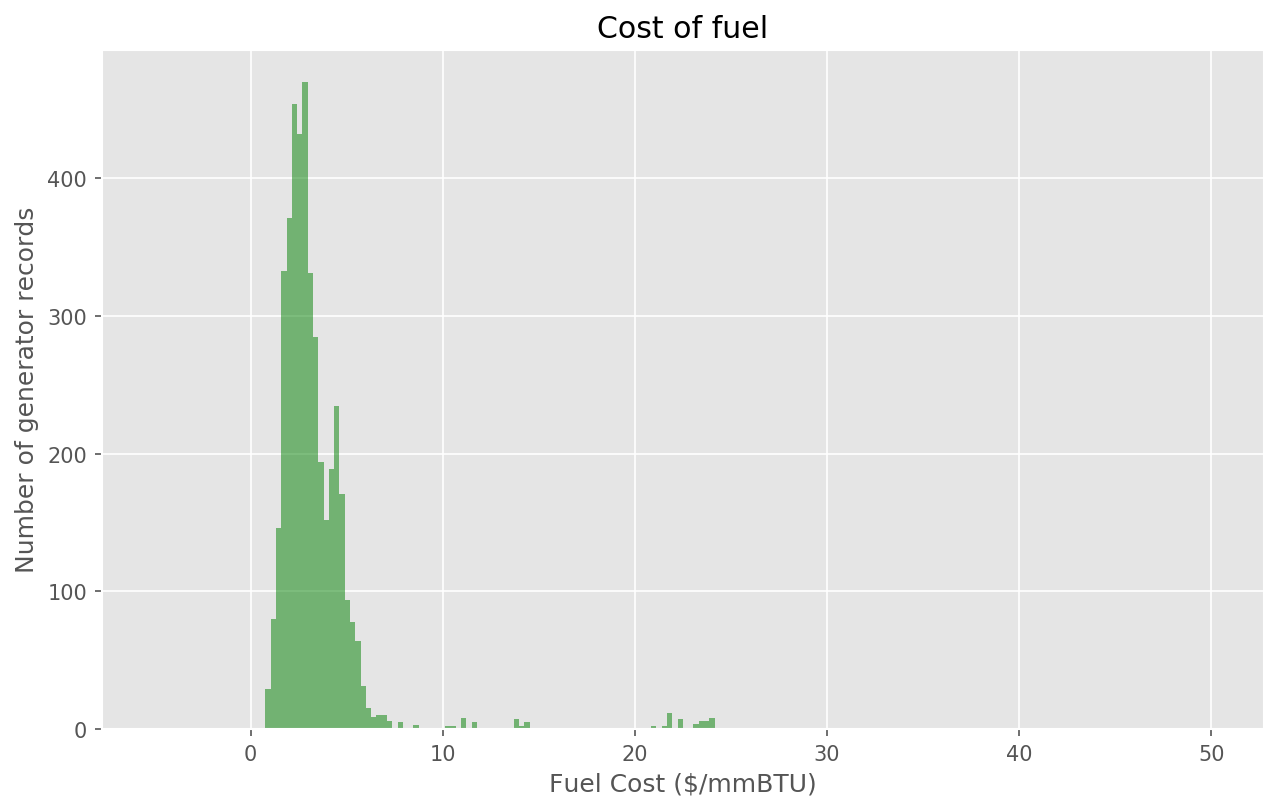

In [118]:
#quick look at spread in fuel_cost_per_mmbtu
plt.hist(mcoe_by_generator.fuel_cost_per_mmbtu_plant, range=(-5,50), bins=200, alpha=0.5, color='green')
plt.xlabel("Fuel Cost ($/mmBTU)")
plt.ylabel("Number of generator records")
plt.title("Cost of fuel")
plt.legend()

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/home/alana/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


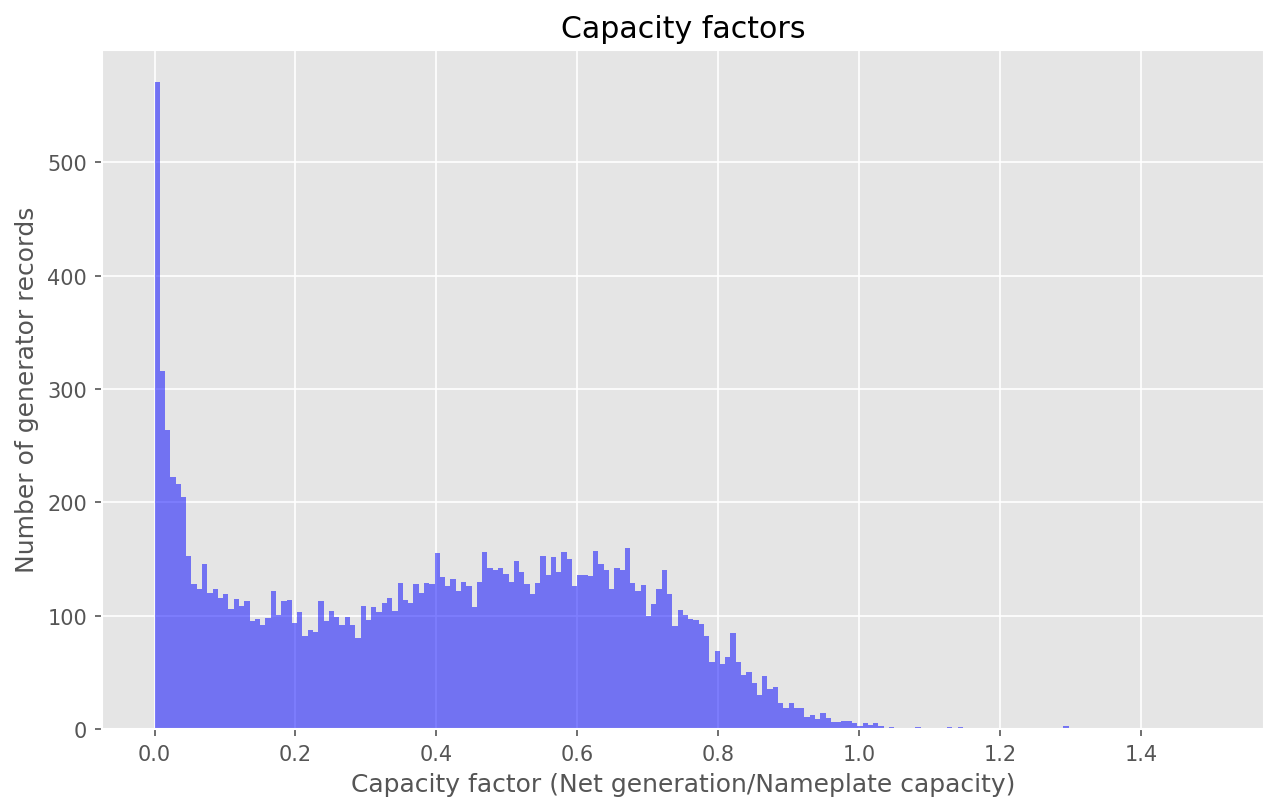

In [119]:
#quick look at capacity factors
plt.hist(mcoe_by_generator.capacity_factor, range=(0,1.5), bins=200, alpha=0.5, color='blue')
plt.xlabel("Capacity factor (Net generation/Nameplate capacity)")
plt.ylabel("Number of generator records")
plt.title("Capacity factors")
plt.legend()

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/home/alana/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


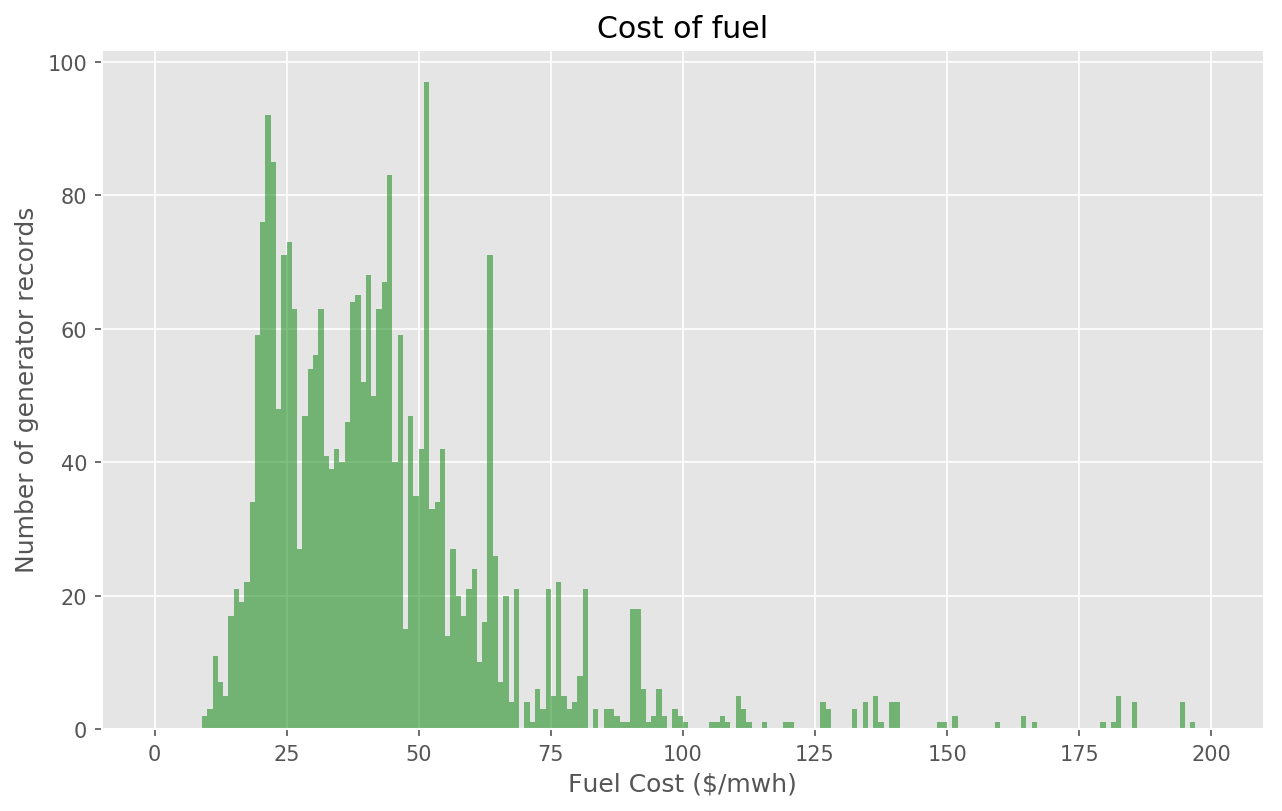

In [120]:
#quick look at spread in fuel_cost_per_mwh for these plants
plt.hist(merged.fuel_cost_per_mwh, range=(0,200), bins=200, alpha=0.5, color='green')
plt.xlabel("Fuel Cost ($/mwh)")
plt.ylabel("Number of generator records")
plt.title("Cost of fuel")
plt.legend()